# 2D variability analysis for HBEC IFN experiment

In [22]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
import itertools
%matplotlib inline

In [23]:
import sys
sys.path.append('/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.4-py3.7.egg')
sys.path.append('/data/home/Github/misc-seq/miscseq/')
import encode
import memento

In [24]:
data_path = '/data_volume/ifn_hbec/'

### Get the TFs

In [71]:
tf_df = pd.read_csv('DatabaseExtract_v_1.01.csv', index_col=0)
tf_df = tf_df[tf_df['TF assessment'] == 'Known motif']
tfs = tf_df['HGNC symbol'].tolist()

### Read the processed RNA data

Focus on the club and bc/club cells and type I interferons for now.

Encode the timestamps to integers.

In [26]:
adata = sc.read(data_path + 'HBEC_type_I_filtered_counts_deep.h5ad')

In [28]:
adata = adata[:, ~adata.var.index.str.startswith('MT-')].copy()
adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'basal/club' else 'bc')
adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'ionocyte/tuft' else 'ion-tuft')

In [29]:
adata.shape

(69958, 36588)

### Setup memento

In [30]:
def assign_q(batch):
    
    if batch == 0:
        return 0.387*0.25
    elif batch == 1:
        return 0.392*0.25
    elif batch == 2:
        return 0.436*0.25
    else:
        return 0.417*0.25

In [31]:
adata.obs['q'] = adata.obs['batch'].apply(assign_q)

In [32]:
memento.setup_memento(adata, q_column='q', trim_percent=0.1)

### Compute correlations for STAT1

In [33]:
tf = 'STAT1'
ct = ['ciliated']
stim = 'beta'

def get_2d_moments(tf, ct, stim):
    
    adata_stim = adata.copy()[
        adata.obs.cell_type.isin(ct) & \
        adata.obs.stim.isin(['control', stim])].copy()
    # time_converter={0:0, int(tp):1}
    # adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])

    memento.create_groups(adata_stim, label_columns=['time', 'donor'])
    memento.compute_1d_moments(adata_stim, min_perc_group=.9)
    moment_1d_df = memento.get_1d_moments(adata_stim, groupby='time')

    memento.compute_2d_moments(adata_stim, list(itertools.product([tf], adata_stim.var.index)))

    moment_df = memento.get_2d_moments(adata_stim, groupby='time')
    
    return moment_df


In [34]:
beta_df = get_2d_moments('STAT1', ['ciliated'], 'beta')
alpha_df = get_2d_moments('STAT1', ['ciliated'], 'alpha')
gamma_df = get_2d_moments('STAT1', ['ciliated'], 'gamma')
lambda_df = get_2d_moments('STAT1', ['ciliated'], 'lambda')

beta_df['stim'] = 'beta'
alpha_df['stim'] = 'alpha'
df = pd.concat([alpha_df, beta_df])

/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.4-py3.7.egg/memento/estimator.py:100: RuntimeWarning: invalid value encountered in log
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


(-0.75, 1)

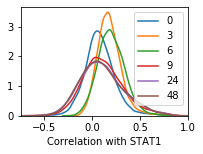

In [23]:
plt.figure(figsize=(3, 2))
for tp in ['0', '3', '6', '9', '24', '48']:#['0', '3', '6', '9', '24', '48']:
    sns.distplot(beta_df['time_' + tp], hist=False, label=tp)
# plt.legend(, frameon=False)
plt.xlabel('Correlation with STAT1')
plt.xlim(-0.75, 1)

In [35]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec

import pandas as pd
import numpy as np
from sklearn.neighbors import KernelDensity

In [55]:
def ridgeplot(df):

    colors = ['#0000ff', '#3300cc', '#660099', '#990066', '#cc0033', '#ff0000']

    gs = grid_spec.GridSpec(6,1)
    fig = plt.figure(figsize=(4,3))

    i = 0

    ax_objs = []
    for i, tp in enumerate(['0', '3', '6', '9', '24', '48'][::-1]):
        x = df['time_' + tp].values
        x = x[np.isfinite(x)]
        x_d = np.linspace(-0.7,1, 1000)

        kde = KernelDensity(bandwidth=0.025, kernel='gaussian')
        kde.fit(x[:, None])

        logprob = kde.score_samples(x_d[:, None])

        # creating new axes object
        ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

        # plotting the distribution
        ax_objs[-1].plot(x_d, np.exp(logprob),lw=3, color=colors[i])
    #     ax_objs[-1].fill_between(x_d, np.exp(logprob), alpha=1,color=colors[i])
    
        if i == 0:
            mode_corr = x_d[np.argmax(logprob)]
#             ax_objs[-1].plot([mode_corr, mode_corr], [0, 10])

        # setting uniform x and y lims
        ax_objs[-1].set_xlim(-0.4,0.7)
    #     ax_objs[-1].set_ylim(0,2.5)

        # make background transparent
        rect = ax_objs[-1].patch
        rect.set_alpha(0)

        # remove borders, axis ticks, and labels
        ax_objs[-1].set_yticklabels([])

        if i == 6-1:
            ax_objs[-1].set_xlabel("Correlation", fontsize=10,fontweight="bold")
        else:
            ax_objs[-1].set_xticklabels([])
            ax_objs[-1].set_xticks([])

        spines = ["top","right","left","bottom"]
        for s in spines:
            ax_objs[-1].spines[s].set_visible(False)
    #     
        ax_objs[-1].set_yticks([])
    #     adj_country = country.replace(" ","\n")
        ax_objs[-1].text(-0.5,0,tp,fontweight="bold",fontsize=14,ha="right")
        i += 1

    gs.update(hspace=-0.7)
    
#     plt.plot([mode_corr, mode_corr], [0, 10])

    # fig.text(0.07,0.85,"Distribution of Aptitude Test Results from 18 – 24 year-olds",fontsize=20)

    plt.tight_layout()
    plt.show()

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


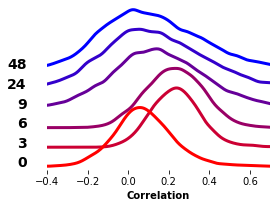

In [56]:
ridgeplot(alpha_df)

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


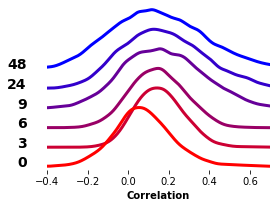

In [40]:
ridgeplot(gamma_df)

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


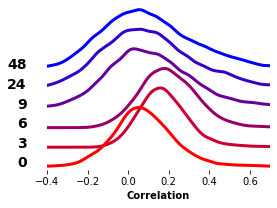

In [41]:
ridgeplot(beta_df)

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


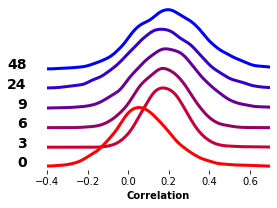

In [42]:
ridgeplot(lambda_df)

### Look for STAT1 DC genes

In [12]:
cts = [['ciliated'], ['bc', 'basal']]
tps = ['3', '6', '9', '24', '48']
stims = ['alpha', 'beta', 'gamma', 'lambda']

In [13]:
import os

In [14]:
done_files = os.listdir('/data_volume/ifn_hbec/tf_test/')

In [14]:
tf = 'STAT1'

cts = [['ciliated']]
tps = ['3']
stims = ['beta']


for ct in cts:
    for tp in tps:
        for stim in stims:
            
            fname = '{}_{}_{}_{}.h5ad'.format('-'.join(ct), stim, tp, tf)
            if fname in done_files:
                continue
                            
            print('starting', ct, tp, stim)

            adata_stim = adata.copy()[
                adata.obs.cell_type.isin(ct) & \
                adata.obs.stim.isin(['control', stim]) & \
                adata.obs.time.isin(['0',tp]), :].copy()
            time_converter={0:0, int(tp):1}
            adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])

            memento.create_groups(adata_stim, label_columns=['time_step', 'donor'])
            memento.compute_1d_moments(adata_stim, min_perc_group=.9)
            memento.compute_2d_moments(adata_stim, list(itertools.product([tf], adata_stim.var.index)))

            moment_df = memento.get_2d_moments(adata_stim, groupby='time_step')
            moment_df.to_csv('/data_volume/ifn_hbec/coex_test/moments_{}_{}_{}_{}.csv'.format('-'.join(ct), stim, tp, tf), index=False)
            gene_list = adata_stim.var.index.tolist()#moment_df[(moment_df['time_step_0'] > 0.35) | (moment_df['time_step_1'] > 0.35)].gene_2.tolist()

            memento.compute_2d_moments(adata_stim, list(itertools.product([tf], gene_list)))

            memento.ht_2d_moments( 
                adata_stim, 
                formula_like='1 + time_step',
                cov_column='time_step', 
                num_boot=10000, 
                verbose=1,
                num_cpus=13)

            if 'mv_regressor' in adata_stim.uns['memento']:
                del adata_stim.uns['memento']['mv_regressor']
            adata_stim.write('/data_volume/ifn_hbec/tf_test/{}_{}_{}_{}.h5ad'.format('-'.join(ct), stim, tp, tf))

### What are the STAT1 DC genes?

In [57]:
stim = 'beta'
tp = '3'
ct = ['ciliated']

fname = '/data_volume/ifn_hbec/tf_test/{}_{}_{}_{}.h5ad'.format('-'.join(ct), stim, tp, tf)
adata_result = sc.read(fname)

In [105]:

fname = '/data_volume/ifn_hbec/tf_test/{}_{}_{}_{}.h5ad'.format('-'.join(ct), stim, tp, tf)
adata_result = sc.read(fname)

moments = memento.get_2d_moments(adata_result, groupby='time')
res_df = memento.get_2d_ht_result(adata_result)
# rel_res_df = memento.get_2d_ht_result(adata_stim)

In [106]:
moments.query('gene_2.str.startswith("HLA-")', engine='python')

,gene_1,gene_2,time_3,time_0
324,STAT1,HLA-F,0.516336,0.303196
325,STAT1,HLA-A,0.435438,0.184255
326,STAT1,HLA-E,0.626379,0.415575
327,STAT1,HLA-C,0.530611,0.319793
328,STAT1,HLA-B,0.437998,0.201227


In [80]:
wired_pairs = moments.query('time_0 > 0.25 | time_{} > 0.25'.format(tp))

In [81]:
filtered_res_df = df.merge(wired_pairs, on=['gene_1', 'gene_2'])
filtered_res_df['corr_fdr'] = memento.util._fdrcorrect(filtered_res_df['corr_pval'])

In [ ]:
for g in filtered_res_df.query('corr_fdr < 0.1 & corr_coef > 0').gene_2.tolist():
    print(g)

In [52]:
filtered_res_df.shape

(869, 7)

In [53]:
res_df.shape

(891, 5)

### Re-run the STAT1 anaylsis for subset

In [15]:
tf = 'STAT1'

cts = [['ciliated']]
tps = ['3', '6', '9', '24', '48']
stims = ['alpha', 'beta', 'gamma', 'lambda']


for ct in cts:
    for tp in tps:
        for stim in stims:
            
#             fname = '{}_{}_{}_{}.h5ad'.format('-'.join(ct), stim, tp, tf)
#             if fname in done_files:
#                 continue
                            
            print('starting', ct, tp, stim)

            adata_stim = adata.copy()[
                adata.obs.cell_type.isin(ct) & \
                adata.obs.stim.isin(['control', stim]) & \
                adata.obs.time.isin(['0',tp]), :].copy()
            time_converter={0:0, int(tp):1}
            adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])

            memento.create_groups(adata_stim, label_columns=['time_step', 'donor'])
            memento.compute_1d_moments(adata_stim, min_perc_group=.9)
            
            gene_list = adata_stim.var.index.tolist()
            
            memento.compute_2d_moments(adata_stim, list(itertools.product([tf], adata_stim.var.index)))

            moment_df = memento.get_2d_moments(adata_stim, groupby='time_step')
            moment_df.to_csv('/data_volume/ifn_hbec/tf_test/moments_{}_{}_{}_{}.csv'.format('-'.join(ct), stim, tp, tf), index=False)
#             gene_list = adata_stim.var.index.tolist()#moment_df[(moment_df['time_step_0'] > 0.35) | (moment_df['time_step_1'] > 0.35)].gene_2.tolist()

#             memento.compute_2d_moments(adata_stim, list(itertools.product([tf], gene_list)))

#             memento.ht_2d_moments( 
#                 adata_stim, 
#                 formula_like='1 + time_step',
#                 cov_column='time_step', 
#                 num_boot=10000, 
#                 verbose=1,
#                 num_cpus=13)

#             if 'mv_regressor' in adata_stim.uns['memento']:
#                 del adata_stim.uns['memento']['mv_regressor']
#             adata_stim.write('/data_volume/ifn_hbec/tf_test/{}_{}_{}_{}.h5ad'.format('-'.join(ct), stim, tp, tf))

starting ['ciliated'] 3 alpha
starting ['ciliated'] 3 beta
starting ['ciliated'] 3 gamma


/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.4-py3.7.egg/memento/main.py:578: RuntimeWarning: invalid value encountered in true_divide


starting ['ciliated'] 3 lambda
starting ['ciliated'] 6 alpha
starting ['ciliated'] 6 beta
starting ['ciliated'] 6 gamma
starting ['ciliated'] 6 lambda
starting ['ciliated'] 9 alpha
starting ['ciliated'] 9 beta
starting ['ciliated'] 9 gamma
starting ['ciliated'] 9 lambda
starting ['ciliated'] 24 alpha
starting ['ciliated'] 24 beta
starting ['ciliated'] 24 gamma
starting ['ciliated'] 24 lambda
starting ['ciliated'] 48 alpha
starting ['ciliated'] 48 beta
starting ['ciliated'] 48 gamma
starting ['ciliated'] 48 lambda


### Compile STAT1 DC and correlation status

In [58]:
stim = 'beta'
ct = ['ciliated']
tf = 'STAT1'

In [59]:

for tp in ['3', '6', '9', '24', '48']:
    
    print(tp)

    fname = '/data_volume/ifn_hbec/tf_test/{}_{}_{}_{}.h5ad'.format('-'.join(ct), stim, tp, tf)
    adata_result = sc.read(fname)
    
#     moments = memento.get_2d_moments(adata_result, groupby='time_step').rename(columns={'time_step_0':'time_0', 'time_step_1':'time_'+tp})
    moments = pd.read_csv('/data_volume/ifn_hbec/tf_test/moments_{}_{}_{}_{}.csv'.format('-'.join(ct), stim, tp, tf)).rename(columns={'time_step_0':'time_0', 'time_step_1':'time_'+tp})
    res_df = memento.get_2d_ht_result(adata_result)\
        .rename(columns={
            'corr_coef':'corr_coef' + '_' + tp,
            'corr_pval':'corr_pval' + '_' + tp})
    
    if tp == '3':

        pv_df = res_df[['gene_1', 'gene_2', 'corr_pval' + '_' + tp]].copy()
        coef_df = res_df[['gene_1', 'gene_2', 'corr_coef' + '_' + tp]].copy()
        moment_df = moments[['gene_1', 'gene_2', 'time_0', 'time_3']].copy()
        
    else:
        
        pv_df = pv_df.merge(res_df[['gene_1', 'gene_2', 'corr_pval' + '_' + tp]].copy(), on=['gene_1', 'gene_2'], how='outer')
        coef_df = coef_df.merge(res_df[['gene_1', 'gene_2', 'corr_coef' + '_' + tp]].copy(), on=['gene_1', 'gene_2'], how='outer')
        moment_df = moment_df.merge(moments[['gene_1', 'gene_2', 'time_{}'.format(tp)]].copy(), on=['gene_1', 'gene_2'], how='outer')
    
    
    

3
6
9
24
48


In [60]:
moment_df.query('gene_2.isin(["HLA-A", "HLA-B", "HLA-C", "B2M"])', engine='python')

,gene_1,gene_2,time_0,time_3,time_6,time_9,time_24,time_48
3131,STAT1,HLA-A,0.172667,0.411305,0.400808,0.164412,0.136630,0.105955
3153,STAT1,HLA-C,0.314121,0.473929,0.518224,0.414040,0.395678,0.318020
3154,STAT1,HLA-B,0.196586,0.417520,0.431934,0.245321,0.202433,0.157760
6779,STAT1,B2M,0.177316,0.348284,0.417817,0.101426,0.045659,0.056695


### Check 2D moments over time

In [20]:
isg_genes = ['ISG15', 'MX1', 'MX2', 'ISG15', 'OAS1', 'OAS2', 'OAS3', 'OASL',]

In [21]:
moment_df.query('gene_2.isin(@isg_genes)', engine='python')

,gene_1,gene_2,time_0,time_3,time_6,time_9,time_24,time_48
3,STAT1,ISG15,0.713398,0.472722,0.484757,0.494712,0.440472,0.503382
5996,STAT1,OAS1,0.646565,0.498528,0.492114,0.598161,0.472078,0.535351
5997,STAT1,OAS3,0.732475,0.525359,0.516637,0.595635,0.591296,0.635312
5998,STAT1,OAS2,0.899163,0.645379,0.618742,0.618230,0.649674,0.663459
6029,STAT1,OASL,0.549513,0.273677,0.252218,0.320974,0.270424,0.478260
8913,STAT1,MX2,0.791370,0.446193,0.431638,0.504710,0.398981,0.529850
8914,STAT1,MX1,0.823748,0.473797,0.495038,0.559051,0.494222,0.590052


In [139]:
moment_df.query('gene_2.isin(["HLA-A", "HLA-B", "HLA-C", "B2M"])', engine='python')

,gene_1,gene_2,time_0,time_3,time_6,time_9,time_24,time_48
3097,STAT1,HLA-A,0.184255,0.275632,0.204322,0.135832,0.103195,0.100389
3118,STAT1,HLA-C,0.319793,0.405229,0.340785,0.283306,0.145822,0.176469
3119,STAT1,HLA-B,0.201227,0.302763,0.290189,0.211899,0.122095,0.082566
6662,STAT1,B2M,0.184621,0.249761,0.203064,0.147616,0.055379,0.055576


In [117]:
coef_df.query('gene_2.isin(["HLA-A", "HLA-B", "HLA-C", "B2M"])', engine='python')

,gene_1,gene_2,corr_coef_3,corr_coef_6,corr_coef_9,corr_coef_24,corr_coef_48
325,STAT1,HLA-A,0.404269,0.387095,NaN,NaN,NaN
327,STAT1,HLA-C,0.273931,0.351479,0.211282,0.15942,NaN
328,STAT1,HLA-B,0.381630,0.406874,NaN,NaN,NaN
649,STAT1,B2M,0.291344,0.413924,NaN,NaN,NaN


In [140]:
pv_df.query('gene_2.isin(["HLA-A", "HLA-B", "HLA-C", "B2M"])', engine='python')

,gene_1,gene_2,corr_pval_3,corr_pval_6,corr_pval_9,corr_pval_24,corr_pval_48
216,STAT1,HLA-C,0.072993,NaN,NaN,NaN,NaN


In [69]:
vals = moment_df.query('gene_2.isin(["HLA-A", "HLA-B", "HLA-C", "B2M"])', engine='python').values[:, 2:]
# vals = moment_df.query('gene_2.isin(@isg_genes)', engine='python').values[:, 2:]

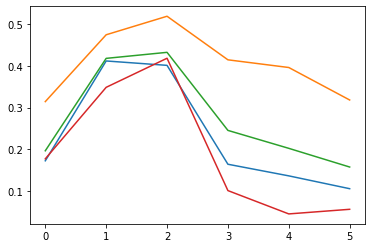

In [70]:
plt.plot(vals.T)

### Check some expresssion level over time

In [207]:
stim = 'alpha'
ct = ['ciliated']

In [208]:
subset = adata[adata.obs['cell_type'].isin(ct) & adata.obs.stim.isin(['control', stim])].copy().copy()
memento.create_groups(subset, label_columns=['time', 'donor'])
memento.compute_1d_moments(subset, min_perc_group=.80)
print('NLRC5' in subset.var.index.tolist())
mean_df = memento.get_1d_moments(subset, groupby='time')[0][['gene'] + ['time_' + str(i) for i in [0, 3, 6, 9, 24, 48]]]
var_df = memento.get_1d_moments(subset, groupby='time')[1][['gene'] + ['time_' + str(i) for i in [0, 3, 6, 9, 24, 48]]]

True


/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.4-py3.7.egg/memento/estimator.py:100: RuntimeWarning: invalid value encountered in log
/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.4-py3.7.egg/memento/main.py:529: RuntimeWarning: invalid value encountered in true_divide
  groupby_var[key] /= groupby_var_count[key]


In [209]:
isg_genes = ['ISG15', 'MX1', 'MX2', 'ISG15', 'OAS1', 'OAS2', 'OAS3', 'OASL',]

In [210]:
mean_df

,gene,time_0,time_3,time_6,time_9,time_24,time_48
0,LINC01409,-2.073328,-2.083385,-1.947781,-2.228607,-2.447309,-2.398632
1,NOC2L,-1.177516,-1.219108,-1.232988,-1.132366,-1.087903,-1.103175
2,PLEKHN1,-2.775626,-2.000231,-1.944417,-1.530974,-1.761761,-2.103361
3,HES4,0.790288,1.310475,1.496799,1.950245,1.793758,1.355431
4,ISG15,1.825076,4.118247,4.428617,4.936904,4.672091,4.189695
...,...,...,...,...,...,...,...
10010,BRCC3,-1.815602,-1.896236,-1.911410,-1.907467,-1.787630,-1.785002
10011,VBP1,-1.051313,-1.292109,-1.350432,-1.412650,-1.101303,-1.127275
10012,TMLHE,-2.636638,-2.477830,-2.617445,-2.468098,-2.743701,-2.508598
10013,VAMP7,-1.429572,-1.679458,-1.675664,-1.659182,-1.644170,-1.903700


In [211]:
isg_mat = mean_df.query('gene.isin(@isg_genes)', engine='python').values[:, 1:]

c1_mat = mean_df.query('gene.isin(["HLA-A", "HLA-B", "HLA-C", "B2M"])', engine='python').values[:, 1:]
# c1_mat = c1_mat/c1_mat[:, 0].reshape(-1,1)

In [212]:
mean_df.query('gene.isin(["HLA-A", "HLA-B", "HLA-C", "B2M"])', engine='python')

,gene,time_0,time_3,time_6,time_9,time_24,time_48
3251,HLA-A,1.656812,2.484910,2.546718,2.387749,2.176116,1.874394
3276,HLA-C,1.829254,2.540602,2.768395,2.888322,2.616492,2.188766
3277,HLA-B,1.967847,2.735884,2.802005,2.850331,2.640588,2.247994
7037,B2M,4.189476,4.461479,4.507913,4.493916,4.345053,4.187041


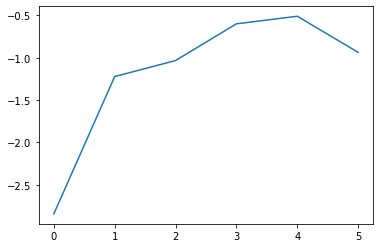

In [213]:
plt.plot(mean_df.query('gene.isin(["NLRC5"])', engine='python').values[0, 1:])

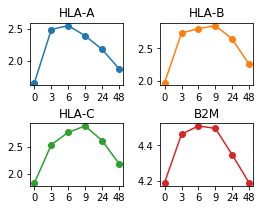

In [214]:
d = mean_df.query('gene.isin(["HLA-A", "HLA-B", "HLA-C", "B2M"])', engine='python')
plt.figure(figsize=(4,3))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
locs = [1, 3, 2, 4]
cs = [0, 2, 1, 3]
num=0
for idx, row in d.iterrows():
    plt.subplot(2,2,locs[num])
    plt.plot(row.values[1:], '-o', color='C'+str(cs[num]))
    plt.title(row['gene'])
    plt.xticks([0, 1, 2, 3, 4, 5], ['0', '3', '6', '9', '24', '48'])
    num +=1


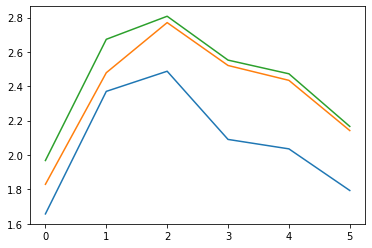

In [173]:
plt.plot(mean_df.query('gene.isin(["HLA-A", "HLA-B", "HLA-C", "B2M"])', engine='python').values[:, 1:].T)

In [60]:
beta_stim = adata[adata.obs['cell_type'].isin(ct) & adata.obs.stim.isin(['control', stim])].copy().copy()

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


([array([698.,   0.,   0.,  37.,   0.,   0.,   0.,   4.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.]),
  array([757.,   0.,   0., 199.,   0.,   0.,   0.,  32.,   0.,   0.,   0.,
           8.,   0.,   0.,   2.])],
 array([0.        , 0.26666668, 0.53333336, 0.8       , 1.0666667 ,
        1.3333334 , 1.6       , 1.8666667 , 2.1333334 , 2.4       ,
        2.6666667 , 2.9333334 , 3.2       , 3.4666667 , 3.7333333 ,
        4.        ], dtype=float32),
 <a list of 2 Lists of Patches objects>)

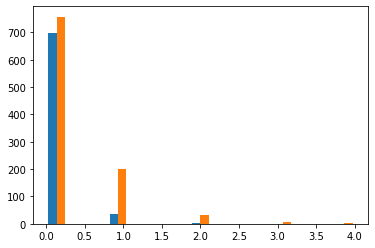

In [61]:
plt.hist([
    beta_stim[beta_stim.obs.time == '0', :][:, 'NLRC5'].X.todense().A1, 
    beta_stim[beta_stim.obs.time == '3', :][:, 'NLRC5'].X.todense().A1],
    bins=15)
# plt.hist(adata[adata.obs.time == '3', :][:, 'NLRC5'].X.todense().A1, bins=15)

In [62]:
df.query('gene.isin(["NLRC5"])', engine='python')

,gene,time_0,time_3,time_6,time_9,time_24,time_48
7798,NLRC5,-2.844202,-1.290465,-0.997472,-0.961713,-0.956975,-0.941885


In [63]:
df.query('gene.isin(["HLA-A", "HLA-B", "HLA-C", "B2M"])', engine='python')

,gene,time_0,time_3,time_6,time_9,time_24,time_48
3342,HLA-A,1.656812,2.370405,2.487690,2.090583,2.035615,1.793220
3367,HLA-C,1.829254,2.479059,2.770877,2.521157,2.434578,2.142253
3368,HLA-B,1.967847,2.673597,2.807899,2.552474,2.472788,2.166302
7264,B2M,4.189476,4.438093,4.546697,4.348129,4.342992,4.125379


### Correlation of MHC I transcripts to canonical TFs

In [ ]:

cts = [['ciliated']]
tps = ['3', '6', '9', '24', '48']
stims = ['alpha', 'beta', 'gamma', 'lambda']


for ct in cts:
    for tp in tps:
        for stim in stims:
            
#             fname = '{}_{}_{}_{}.h5ad'.format('-'.join(ct), stim, tp, tf)
#             if fname in done_files:
#                 continue
                            
            print('starting', ct, tp, stim)

            adata_stim = adata.copy()[
                adata.obs.cell_type.isin(ct) & \
                adata.obs.stim.isin(['control', stim]) & \
                adata.obs.time.isin(['0',tp]), :].copy()
            time_converter={0:0, int(tp):1}
            adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])

            memento.create_groups(adata_stim, label_columns=['time_step', 'donor'])
            memento.compute_1d_moments(adata_stim, min_perc_group=.9)
            
            tf_list = list(set(tfs) & set(adata_stim.var.index))
            
            gene_list = adata_stim.var.index.tolist()
            
            memento.compute_2d_moments(adata_stim, list(itertools.product(tf_list, ["HLA-A", "HLA-B", "HLA-C", "B2M"])))

            moment_df = memento.get_2d_moments(adata_stim, groupby='time_step')
            moment_df.to_csv('/data_volume/ifn_hbec/tf_test/moments_{}_{}_{}_mhc1.csv'.format('-'.join(ct), stim, tp), index=False)


            memento.ht_2d_moments( 
                adata_stim, 
                formula_like='1 + time_step',
                cov_column='time_step', 
                num_boot=10000, 
                verbose=1,
                num_cpus=13)

            if 'mv_regressor' in adata_stim.uns['memento']:
                del adata_stim.uns['memento']['mv_regressor']
            adata_stim.write('/data_volume/ifn_hbec/tf_test/{}_{}_{}_mhc1.h5ad'.format('-'.join(ct), stim, tp))

In [75]:
stim = 'beta'
ct = ['ciliated']
for tp in ['3', '6', '9', '24', '48']:
    
    print(tp)

    
#     moments = memento.get_2d_moments(adata_result, groupby='time_step').rename(columns={'time_step_0':'time_0', 'time_step_1':'time_'+tp})
    moments = pd.read_csv('/data_volume/ifn_hbec/tf_test/moments_{}_{}_{}_mhc1.csv'.format('-'.join(ct), stim, tp)).rename(columns={'time_step_0':'time_0', 'time_step_1':'time_'+tp})
    res_df = memento.get_2d_ht_result(adata_result)\
        .rename(columns={
            'corr_coef':'corr_coef' + '_' + tp,
            'corr_pval':'corr_pval' + '_' + tp})
    
    if tp == '3':

        pv_df = res_df[['gene_1', 'gene_2', 'corr_pval' + '_' + tp]].copy()
        coef_df = res_df[['gene_1', 'gene_2', 'corr_coef' + '_' + tp]].copy()
        moment_df = moments[['gene_1', 'gene_2', 'time_0', 'time_3']].copy()
        
    else:
        
        pv_df = pv_df.merge(res_df[['gene_1', 'gene_2', 'corr_pval' + '_' + tp]].copy(), on=['gene_1', 'gene_2'], how='outer')
        coef_df = coef_df.merge(res_df[['gene_1', 'gene_2', 'corr_coef' + '_' + tp]].copy(), on=['gene_1', 'gene_2'], how='outer')
        moment_df = moment_df.merge(moments[['gene_1', 'gene_2', 'time_{}'.format(tp)]].copy(), on=['gene_1', 'gene_2'], how='outer')
    
    
    

3
6
9
24
48


### Hunt for some relevant TFs

In [225]:
stim = 'alpha'
tp = '6'
ct = ['ciliated']

fname = '/data_volume/ifn_hbec/tf_test/{}_{}_{}_mhc1.h5ad'.format('-'.join(ct), stim, tp)
adata_result = sc.read(fname)

In [226]:

fname = '/data_volume/ifn_hbec/tf_test/{}_{}_{}_mhc1.h5ad'.format('-'.join(ct), stim, tp)
adata_result = sc.read(fname)

moments = memento.get_2d_moments(adata_result, groupby='time')[['gene_1', 'gene_2', 'time_0', 'time_'+tp]]
res_df = memento.get_2d_ht_result(adata_result)
# rel_res_df = memento.get_2d_ht_result(adata_stim)

In [227]:
wired_pairs = moments.query('time_0 > 0 | time_{} > 0'.format(tp))

In [228]:
filtered_res_df = res_df.merge(wired_pairs, on=['gene_1', 'gene_2'])
filtered_res_df['corr_fdr'] = memento.util._fdrcorrect(filtered_res_df['corr_pval'])

In [229]:
pd.set_option('display.max_rows', 500)


In [230]:
res_df.head(5)

,gene_1,gene_2,corr_coef,corr_se,corr_pval
0,FOXA1,HLA-A,0.392587,0.123678,0.002800
1,FOXA1,HLA-B,0.475548,0.112219,0.002092
2,FOXA1,HLA-C,0.630494,0.120908,0.001079
3,FOXA1,B2M,0.363431,0.103738,0.002100
4,ELF3,HLA-A,0.271839,0.070023,0.000859


In [231]:
res_df.query('corr_pval > 0.9')

,gene_1,gene_2,corr_coef,corr_se,corr_pval
9,HNF4G,HLA-B,0.006242,0.227504,0.976002
10,HNF4G,HLA-C,-0.004751,0.218658,0.980802
26,ZNF740,HLA-C,-0.018071,0.253171,0.939906
31,TFAP2A,B2M,-0.002262,0.129791,0.985101
59,NR2F1,B2M,0.004754,0.117746,0.967803
135,NR1D2,B2M,0.014274,0.140669,0.920708
149,MEF2D,HLA-B,0.010081,0.186017,0.958004
152,NR2C1,HLA-A,-0.029014,0.265817,0.917608
174,ZNF254,HLA-C,0.022037,0.252823,0.928407
175,ZNF254,B2M,-0.012917,0.212910,0.947505


In [232]:
res_df.columns

Index(['gene_1', 'gene_2', 'corr_coef', 'corr_se', 'corr_pval'], dtype='object')

In [233]:
filtered_res_df.query('corr_fdr < 0.05 & corr_coef > 0')

,gene_1,gene_2,corr_coef,corr_se,corr_pval,time_0,time_6,corr_fdr
0,FOXA1,HLA-A,0.392587,0.123678,0.002800,-0.010951,0.176177,0.024333
1,FOXA1,HLA-B,0.475548,0.112219,0.002092,-0.105736,0.201577,0.022193
2,FOXA1,HLA-C,0.630494,0.120908,0.001079,-0.110515,0.221616,0.021943
3,FOXA1,B2M,0.363431,0.103738,0.002100,0.051298,0.187765,0.022193
4,ELF3,HLA-A,0.271839,0.070023,0.000859,0.221549,0.390640,0.021886
5,ELF3,HLA-B,0.248512,0.064679,0.003667,0.234490,0.424002,0.028204
6,ELF3,HLA-C,0.289338,0.074276,0.001068,0.213727,0.414076,0.021943
7,ELF3,B2M,0.276534,0.064473,0.000775,0.071917,0.265828,0.021232
11,EGR1,HLA-B,0.198191,0.065515,0.003600,-0.070958,0.130028,0.027854
13,EGR1,B2M,0.204425,0.060815,0.001200,-0.125463,0.018856,0.021943


In [234]:
filtered_res_df.query('corr_fdr < 0.05 & corr_coef > 0')

,gene_1,gene_2,corr_coef,corr_se,corr_pval,time_0,time_6,corr_fdr
0,FOXA1,HLA-A,0.392587,0.123678,0.002800,-0.010951,0.176177,0.024333
1,FOXA1,HLA-B,0.475548,0.112219,0.002092,-0.105736,0.201577,0.022193
2,FOXA1,HLA-C,0.630494,0.120908,0.001079,-0.110515,0.221616,0.021943
3,FOXA1,B2M,0.363431,0.103738,0.002100,0.051298,0.187765,0.022193
4,ELF3,HLA-A,0.271839,0.070023,0.000859,0.221549,0.390640,0.021886
5,ELF3,HLA-B,0.248512,0.064679,0.003667,0.234490,0.424002,0.028204
6,ELF3,HLA-C,0.289338,0.074276,0.001068,0.213727,0.414076,0.021943
7,ELF3,B2M,0.276534,0.064473,0.000775,0.071917,0.265828,0.021232
11,EGR1,HLA-B,0.198191,0.065515,0.003600,-0.070958,0.130028,0.027854
13,EGR1,B2M,0.204425,0.060815,0.001200,-0.125463,0.018856,0.021943


In [236]:
res_df

,gene_1,gene_2,corr_coef,corr_se,corr_pval
0,FOXA1,HLA-A,0.392587,0.123678,0.002800
1,FOXA1,HLA-B,0.475548,0.112219,0.002092
2,FOXA1,HLA-C,0.630494,0.120908,0.001079
3,FOXA1,B2M,0.363431,0.103738,0.002100
4,ELF3,HLA-A,0.271839,0.070023,0.000859
...,...,...,...,...,...
1531,KLF2,B2M,0.116096,0.069041,0.090091
1532,ZBTB11,HLA-A,0.423909,0.194665,0.031597
1533,ZBTB11,HLA-B,0.329830,0.179313,0.070693
1534,ZBTB11,HLA-C,0.254102,0.188581,0.170783


In [237]:
moments.query('gene_2.str.startswith("HLA-")', engine='python')

,gene_1,gene_2,time_0,time_6
0,FOXA1,HLA-A,-0.010951,0.176177
1,FOXA1,HLA-B,-0.105736,0.201577
2,FOXA1,HLA-C,-0.110515,0.221616
4,ELF3,HLA-A,0.221549,0.390640
5,ELF3,HLA-B,0.234490,0.424002
...,...,...,...,...
1529,KLF2,HLA-B,-0.076569,0.104653
1530,KLF2,HLA-C,0.059468,0.185145
1532,ZBTB11,HLA-A,-0.097915,0.038801
1533,ZBTB11,HLA-B,-0.075090,0.067514


### Check correlations to other TFs over time

In [239]:
stim = 'beta'
ct = ['ciliated']
tf = 'STAT1'

In [240]:

for tp in ['3', '6', '9', '24', '48']:
    
    print(tp)

    fname = '/data_volume/ifn_hbec/tf_test/{}_{}_{}_mhc1.h5ad'.format('-'.join(ct), stim, tp)
    adata_result = sc.read(fname)
    
#     moments = memento.get_2d_moments(adata_result, groupby='time_step').rename(columns={'time_step_0':'time_0', 'time_step_1':'time_'+tp})
    moments = pd.read_csv('/data_volume/ifn_hbec/tf_test/moments_{}_{}_{}_mhc1.csv'.format('-'.join(ct), stim, tp)).rename(columns={'time_step_0':'time_0', 'time_step_1':'time_'+tp})
    res_df = memento.get_2d_ht_result(adata_result)\
        .rename(columns={
            'corr_coef':'corr_coef' + '_' + tp,
            'corr_pval':'corr_pval' + '_' + tp})
    
    if tp == '3':

        pv_df = res_df[['gene_1', 'gene_2', 'corr_pval' + '_' + tp]].copy()
        coef_df = res_df[['gene_1', 'gene_2', 'corr_coef' + '_' + tp]].copy()
        moment_df = moments[['gene_1', 'gene_2', 'time_0', 'time_3']].copy()
        
    else:
        
        pv_df = pv_df.merge(res_df[['gene_1', 'gene_2', 'corr_pval' + '_' + tp]].copy(), on=['gene_1', 'gene_2'], how='outer')
        coef_df = coef_df.merge(res_df[['gene_1', 'gene_2', 'corr_coef' + '_' + tp]].copy(), on=['gene_1', 'gene_2'], how='outer')
        moment_df = moment_df.merge(moments[['gene_1', 'gene_2', 'time_{}'.format(tp)]].copy(), on=['gene_1', 'gene_2'], how='outer')
    
    
    

3
6
9
24
48


Text(0, 0.5, 'Corr STAT1')

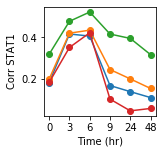

In [241]:
tf = 'STAT1'
plt.figure(figsize=(2,2))
plt.plot(moment_df.query('gene_1 == "{}"'.format(tf)).values[:, 2:].T, '-o')
plt.xticks([0, 1, 2, 3, 4, 5], ['0', '3', '6', '9', '24', '48'])
plt.xlabel('Time (hr)'); plt.ylabel('Corr {}'.format(tf))

In [242]:
tf = 'CREB3'

In [243]:
moment_df.query('gene_1 == "{}"'.format(tf))

,gene_1,gene_2,time_0,time_3,time_6,time_9,time_24,time_48
828,CREB3,HLA-A,0.092283,0.225511,0.230557,0.079328,0.065209,0.104553
829,CREB3,HLA-B,0.172263,0.341903,0.307946,0.155191,0.201031,0.159479
830,CREB3,HLA-C,0.190355,0.365602,0.330579,0.188595,0.240382,0.157265
831,CREB3,B2M,0.193022,0.443010,0.429344,0.321969,0.269825,0.238096


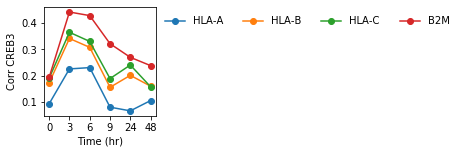

In [244]:
tf = 'CREB3'
plt.figure(figsize=(2,2))
plt.plot(moment_df.query('gene_1 == "{}"'.format(tf)).values[:, 2:].T, '-o')
plt.xticks([0, 1, 2, 3, 4, 5], ['0', '3', '6', '9', '24', '48'])
plt.xlabel('Time (hr)'); plt.ylabel('Corr {}'.format(tf))
plt.legend(['HLA-A', 'HLA-B', 'HLA-C', 'B2M'], ncol=4, frameon=False, bbox_to_anchor=(1,1))

Text(0, 0.5, 'Corr STAT6')

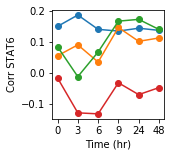

In [245]:
tf = 'STAT6'
plt.figure(figsize=(2,2))
plt.plot(moment_df.query('gene_1 == "{}"'.format(tf)).values[:, 2:].T, '-o')
plt.xticks([0, 1, 2, 3, 4, 5], ['0', '3', '6', '9', '24', '48'])
plt.xlabel('Time (hr)'); plt.ylabel('Corr {}'.format(tf))

Text(0, 0.5, 'Corr JUND')

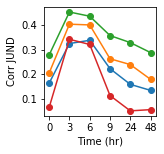

In [246]:
tf = 'JUND'
plt.figure(figsize=(2,2))
plt.plot(moment_df.query('gene_1 == "{}"'.format(tf)).values[:, 2:].T, '-o')
plt.xticks([0, 1, 2, 3, 4, 5], ['0', '3', '6', '9', '24', '48'])
plt.xlabel('Time (hr)'); plt.ylabel('Corr {}'.format(tf))

Text(0, 0.5, 'Corr ETS2')

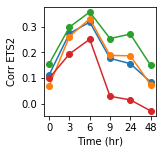

In [249]:
tf = 'ETS2'
plt.figure(figsize=(2,2))
plt.plot(moment_df.query('gene_1 == "{}"'.format(tf)).values[:, 2:].T, '-o')
plt.xticks([0, 1, 2, 3, 4, 5], ['0', '3', '6', '9', '24', '48'])
plt.xlabel('Time (hr)'); plt.ylabel('Corr {}'.format(tf))